a.) plot the surface potential of a charged ring with boundary conditions 0 at the edge of the grid. print the potential values.

To plot a ring, one converted the x, y coordinates into polar form, looping over an updating theta up to $2\pi$ $to account for the charges along the ring. Different steps of $\theta$ should be used based on the number of grid points Nx and Ny. More grid points allows for a smoother surface. 

b.) the number of grid points is proportional to the smoothness of the potential. the more points, the more refined the image looks. 

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0009560032484465088, 0.0019142762534551, 0.0028754396226044012, 0.0038398716708169145, 0.00480758497124164, 0.005778103154964041, 0.006750340113363004, 0.007722485307807514, 0.008691900651320644, 0.009655036128180642, 0.010607372538349941, 0.011543399960022393, 0.012456639233031214, 0.013339710869203035, 0.014184451974594864, 0.014982078737778633, 0.015723392066800377, 0.016399028052123264, 0.016999759852518247, 0.017516854183724295, 0.01794246370516911, 0.01826999962036324, 0.018494405558287897, 0.018612281597247708, 0.01862188583873344, 0.018523098904378053, 0.018317423206087927, 0.018008017920515276, 0.01759969907741008, 0.01709881928226187, 0.016512998460283358, 0.01585075549264851, 0.015121119108127853, 0.014333273766355565, 0.

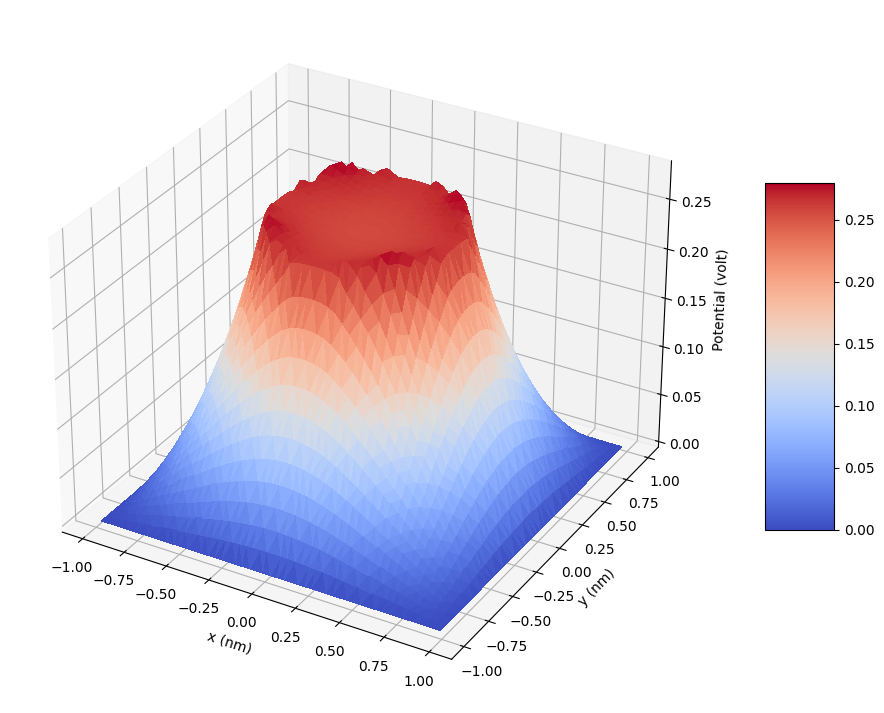

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import time as time
from matplotlib import cm # cool warm colormap (red(+) blue(-))


def encode(i, j, Ny):
    """
    Takes matrix element i,j and encodes element based on the coordinate parameter
    :param i: i index in the matrix
    :param j: j index in the matrix
    :param n_y: 
    :return: integer value associated with alpha
    """
    return int(i*Ny+j)

def i_encode(a, Ny):
    """
    :param a: integer value from encode
    :param n_y: parameter for coordinate system
    :return: tuple integer value after division and its remainder
    """
    return a//Ny, a % Ny

def jacobi(A, b, epsilon=1e-8, maxiter=5000, omega=1, fixed=None, debug=False):
    """
    This takes a linear set of equations in the form of matrix equations and solves them.
    :param A: numpy array - matrix input
    :param b: numpy array - rhs of linear equations
    :param epsilon: float - error paramter
    :param maxiter: float -  maximum iterations for convergence onto the solution
    :param omega: float - parameter for convergence
    :param fixed: parameter for boundary conditions
    :param debug: boolean 
    :return: 
    """
    diag = np.diag(np.diag(A))
    LU = A - diag
    x = np.zeros(len(b))
    diag_inverse = np.diag(1 / np.diag(diag))
    if fixed == None:
        for i in range(maxiter):
            x_new = omega * np.dot(diag_inverse, b - np.dot(LU, x)) + (1 - omega) * x
            res = np.linalg.norm(x_new - x)
            if debug:  # remove later
                print(f'residue = {res}')
            if res < epsilon:
                return x_new
            x = x_new.copy()
        raise Exception(f'Jacobi did not converge in {maxiter} steps')
        # return x
    else:
        for i in range(maxiter):
            for index in fixed:
                x[index] = fixed[index]
            x_new = omega * np.dot(diag_inverse, b - np.dot(LU, x)) + (1 - omega) * x
            for index in fixed:
                x_new[index] = fixed[index]
            res = np.linalg.norm(x_new - x)
            if debug:
                print(f'residue = {res}')
            if res < epsilon:
                return x_new
            x = x_new.copy()
        raise Exception(f'Jacobi did not converge in {maxiter} steps')
        # return x
def Poisson_2D(cmin, cmax, Nx, Ny, method='jacobi'):
    """
    :param cmin: lower most grid pt
    :param cmax: upper most grid pt
    :param Nx: number of points in x
    :param Ny: number of points in y
    :param method: jacobi from linear solver
    :return: mesh potential and time
    """
    def real2grid(x, y, cmin, cmax, Nx, Ny):
        grid_pt = np.zeros(2)
        if x < cmin[0] or x > cmax[0] or y < cmin[1] or y > cmax[1]:
            raise Exception(f'real2grid point {p} is outside boundary of box')
        else:
            delta = np.zeros(2)
            delta[0] = (cmax[0] - cmin[0])/Nx
            delta[1] = (cmax[1] - cmin[1])/Ny
            grid_pt[0] = int((x - cmin[0]) / delta[0])
            grid_pt[1] = int((y - cmin[1]) / delta[1])
        return grid_pt[0], grid_pt[1]

    def grid2real(i, j, cmin, d):
        return cmin[0] + (i + 0.5) * d[0], cmin[1] + (j + 0.5) * d[1]

    def constant_bc(cmin, cmax, Nx, Ny):
        alpha = encode(0, 0, Ny)  # initial alpha for 00 matrix element
        V0 = 0.0 # potential at boundary
        V1 = 5e-4
        bc = {alpha:V0}  # initializes boundary conditions on the edge

        for i in range(Nx): # sets outer mesh entries to 0
            alpha = encode(i, 0, Ny)
            bc.update({alpha:V0}) 
            alpha = encode(i, Ny - 1, Ny)
            bc.update({alpha:V0})

        for j in range(Ny): # sets outer mesh entries to 0
            alpha = encode(0, j, Ny)
            bc.update({alpha:V0})
            alpha = encode(Nx - 1, j, Ny)
            bc.update({alpha:V0})

        bc = dict(sorted(bc.items()))
        return bc

    def right_hand_side(cmin, cmax, Nx, Ny, val):
        """
        sets up the charge distribution for the Poisson's equation
        :param cmin: lowermost coordinate in the grid (-1, -1)
        :param cmax: uppermost coordinate in the grid (1, 1)
        :param Nx: number of points in the x direction
        :param Ny:  number of points in the y direction
        :param val: charge of the electron/proton dimensionless
        :return: b - numpy array, rhs of the linear equations to be solved
        """
        N = Nx * Ny
        b = np.zeros(N)
        
        radius = 0.5 # nm
        theta = 0
        dtheta = np.pi/180
        
        while theta <= 2*np.pi:
            x_val = radius * np.cos(theta)
            y_val = radius * np.sin(theta)
            i, j = real2grid(x_val, y_val, cmin, cmax, Nx, Ny)
            alpha = encode(i, j, Ny)
            b[alpha] = val
            theta = theta + dtheta

        return b
    
    epsilon_0 = 8.854E-12 # Farad/m
    chi =1E-9 # scaling for space (nm)
    C = 1.6E-19 # electron charge
    phi_0 = C/(epsilon_0*chi) # potential dimless

    rho = -1.6e8 # charge density of 1 e/nm^3 in C/m^3
    rho_p = rho*chi**3/C

    D = np.zeros(2)
    D[0] = (cmax[0] - cmin[0])/Nx
    D[1] = (cmax[1] - cmin[1])/Ny

    N = Nx * Ny

    A = np.zeros((N, N))
    b = right_hand_side(cmin, cmax, Nx, Ny, rho_p)
    bc = constant_bc(cmin, cmax, Nx, Ny)

    for i in range(Nx):
        for j in range(Ny):
            alpha = encode(i, j, Ny)
            aa = encode(i+1, j, Ny)
            bb = encode(i-1, j, Ny)
            cc = encode(i, j+1, Ny)
            dd = encode(i, j-1, Ny)

            A[alpha][alpha] = -2/(D[0]*D[0]) - 2/(D[1]*D[1])

            try:
                A[alpha][aa] = 1/(D[0]*D[0])
            except Exception as e:
                pass

            if bb >= 0:
                A[alpha][bb] = 1/(D[0]*D[0])
            try:
                A[alpha][cc] = 1//(D[1]*D[1])
            except Exception as e:
                pass

            if dd >= 0:
                A[alpha][dd] = 1/(D[1]*D[1])
    
    if method == 'jacobi':
        begin_time = time.time()
        y = jacobi(A, b, fixed=bc)
        end_time = time.time()
        compute_time = (end_time - begin_time) * 1000
    # using the jacobi method
    """
    elif method == 'gaussian_elimination':
        begin_time = time.time()
        y = gaussian_elimination(A, b, fixed=bc)
        end_time = time.time()
        compute_time = (end_time - begin_time) * 1000
    """
    X = []
    Y = []
    Potential = []
    # collects the potential into a single array
    for alpha, pot in enumerate(y):
        i, j = i_encode(alpha, Ny)
        xx, yy = grid2real(i, j, cmin, D)
        X.append(xx)
        Y.append(yy)
        Potential.append(pot*phi_0)
    return X, Y, Potential, compute_time

cmin = np.array([-1, -1]) # in nm
cmax = np.array([1, 1]) # in nm
x, y, p, t = Poisson_2D(cmin, cmax, 50, 50)
print(p)

fig = plt.figure(figsize=(16, 9))
ax = plt.axes(projection='3d')
surface = ax.plot_trisurf(x, y, p, cmap=cm.coolwarm, linewidth=0, antialiased=False)

ax.set_xlabel("x (nm)")
ax.set_ylabel("y (nm)")
ax.set_zlabel("Potential (volt)")
fig.colorbar(surface, shrink=0.5, aspect=5)
plt.show()
